In [1]:
import pandas as pd
import sqlite3
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

## Load in data and clean

In [2]:
conn = sqlite3.connect('Data/unzippedData/im.db')

In [3]:
df_imdb = pd.read_sql("""
SELECT movie_basics.movie_id, primary_title, runtime_minutes, genres, averagerating, numvotes
FROM movie_ratings 
JOIN movie_basics
ON movie_basics.movie_id = movie_ratings.movie_id
""", conn)
df_imdb.head()

,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes
0,tt10356526,Laiye Je Yaarian,117.0,Romance,8.3,31
1,tt10384606,Borderless,87.0,Documentary,8.9,559
2,tt1042974,Just Inès,90.0,Drama,6.4,20
3,tt1043726,The Legend of Hercules,99.0,"Action,Adventure,Fantasy",4.2,50352
4,tt1060240,Até Onde?,73.0,"Mystery,Thriller",6.5,21


In [4]:
df_imdb['genres'] = df_imdb['genres'].str.split(',')
df_imdb['complexity'] = df_imdb['genres'].apply(lambda x: len(x) if x is not None else None)
df_imdb['complexity']= df_imdb['complexity'].apply(lambda x: 'Low' if x==1 else ('Medium' if x==2 else ('High' if x==3 else None)))
df_imdb['complexity'].value_counts(dropna=False)

complexity
Low       36192
High      18578
Medium    18282
None        804
Name: count, dtype: int64

In [5]:
print('Dataframe description:')
print(df_imdb.describe())
print('\n-----------------------------------------------------------')
print('Dataframe info:')
print(df_imdb.info())
print('\ndf imdb first 5 rows:')
df_imdb.head()

Dataframe description:
       runtime_minutes  averagerating      numvotes
count     66236.000000   73856.000000  7.385600e+04
mean         94.654040       6.332729  3.523662e+03
std         208.574111       1.474978  3.029402e+04
min           3.000000       1.000000  5.000000e+00
25%          81.000000       5.500000  1.400000e+01
50%          91.000000       6.500000  4.900000e+01
75%         104.000000       7.400000  2.820000e+02
max       51420.000000      10.000000  1.841066e+06

-----------------------------------------------------------
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   runtime_minutes  66236 non-null  float64
 3   genres           73052 non-null  object 
 4   averagerating    73856 non-null  float64
 5

,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes,complexity
0,tt10356526,Laiye Je Yaarian,117.0,[Romance],8.3,31,Low
1,tt10384606,Borderless,87.0,[Documentary],8.9,559,Low
2,tt1042974,Just Inès,90.0,[Drama],6.4,20,Low
3,tt1043726,The Legend of Hercules,99.0,"[Action, Adventure, Fantasy]",4.2,50352,High
4,tt1060240,Até Onde?,73.0,"[Mystery, Thriller]",6.5,21,Medium


In [6]:
rt_t13 = df_imdb['runtime_minutes'].quantile(1/3)
rt_t23 = df_imdb['runtime_minutes'].quantile(2/3)

df_imdb['rt_cat']= df_imdb['runtime_minutes'].apply(lambda x: None if np.isnan(x) 
                                                       else ('Short' if x <= rt_t13 
                                                             else ('Medium' if x <= rt_t23 else 'Long')))

In [7]:
df_finance = pd.read_csv("Data/zippedData/tn.movie_budgets.csv.gz")
df_finance['release_date'] = pd.to_datetime(df_finance['release_date'])
df_finance['year'] = df_finance['release_date'].dt.year
df_finance = df_finance[df_finance['year']<2019].reset_index(drop=True)

In [8]:
# Import information about budgets and profits
df_finance = pd.read_csv("Data/zippedData/tn.movie_budgets.csv.gz")

df_finance['release_date'] = pd.to_datetime(df_finance['release_date'])

columns_to_clean = ['domestic_gross', 'worldwide_gross', 'production_budget']

for col in columns_to_clean:
    df_finance[col] = df_finance[col].str.replace('[$,]', '', regex=True).astype(np.int64)

df_finance['domestic_profit'] = df_finance['domestic_gross'] - df_finance['production_budget']
df_finance['domestic_roi'] = df_finance['domestic_profit']/df_finance['production_budget']

df_finance['worldwide_profit'] = df_finance['worldwide_gross'] - df_finance['production_budget']
df_finance['worldwide_roi'] = df_finance['worldwide_profit']/df_finance['production_budget']



In [9]:
print('Dataframe description:')
print(df_finance.describe())
print('\n-----------------------------------------------------------')
print('Dataframe info:')
print(df_finance.info())
print('\ndf_finance first 5 rows:')
df_finance.head()

Dataframe description:
                id                   release_date  production_budget  \
count  5782.000000                           5782       5.782000e+03   
mean     50.372363  2004-07-06 05:20:31.546177792       3.158776e+07   
min       1.000000            1915-02-08 00:00:00       1.100000e+03   
25%      25.000000            2000-04-22 18:00:00       5.000000e+06   
50%      50.000000            2007-03-02 00:00:00       1.700000e+07   
75%      75.000000            2012-12-25 00:00:00       4.000000e+07   
max     100.000000            2020-12-31 00:00:00       4.250000e+08   
std      28.821076                            NaN       4.181208e+07   

       domestic_gross  worldwide_gross  domestic_profit  domestic_roi  \
count    5.782000e+03     5.782000e+03     5.782000e+03   5782.000000   
mean     4.187333e+07     9.148746e+07     1.028557e+07      1.983540   
min      0.000000e+00     0.000000e+00    -3.072376e+08     -1.000000   
25%      1.429534e+06     4.125415e+

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,domestic_roi,worldwide_profit,worldwide_roi
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,335507625,0.789430,2351345279,5.532577
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,-169536125,-0.412899,635063875,1.546673
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-307237650,-0.877822,-200237650,-0.572108
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,128405868,0.388403,1072413963,3.243841
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,303181382,0.956408,999721747,3.153696


## Merge dataframes and visualize relationships

In [10]:
# Prepare columns to merge on
df_imdb['primary_title'] = df_imdb['primary_title'].str.lower()
df_imdb['primary_title'] = df_imdb['primary_title'].str.replace(r'\([^)]*\)', '', regex=True)

df_finance['movie'] = df_finance['movie'].str.lower()
df_finance['movie'] = df_finance['movie'].str.replace(r'\([^)]*\)', '', regex=True)

In [11]:
df_merge = pd.merge(df_finance, df_imdb, left_on='movie', right_on='primary_title', how='inner')

print(f"df shape before dropping duplicates = {df_merge.shape}")
df_merge = df_merge.drop_duplicates(subset='movie', keep='first')
print(f"df shape after dropping duplicates = {df_merge.shape}\n")

print('Dataframe description:')
print(df_merge.describe())
print('\n-----------------------------------------------------------')
print('Dataframe info:')
print(df_merge.info())
print('\ndf_merge first 5 rows:')
df_merge.head()

df shape before dropping duplicates = (2935, 18)
df shape after dropping duplicates = (2178, 18)

Dataframe description:
                id                   release_date  production_budget  \
count  2178.000000                           2178       2.178000e+03   
mean     50.623508  2011-11-20 01:26:36.694214912       3.693123e+07   
min       1.000000            1927-08-12 00:00:00       1.400000e+03   
25%      26.000000            2011-01-28 00:00:00       5.000000e+06   
50%      50.500000            2013-08-23 00:00:00       1.800000e+07   
75%      75.000000            2015-11-23 18:00:00       4.500000e+07   
max     100.000000            2019-12-31 00:00:00       4.250000e+08   
std      28.542704                            NaN       5.090320e+07   

       domestic_gross  worldwide_gross  domestic_profit  domestic_roi  \
count    2.178000e+03     2.178000e+03     2.178000e+03   2178.000000   
mean     4.598551e+07     1.120645e+08     9.054286e+06      0.906310   
min      0.

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,domestic_roi,worldwide_profit,worldwide_roi,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes,complexity,rt_cat
0,1,2009-12-18,avatar,425000000,760507625,2776345279,335507625,0.789430,2351345279,5.532577,tt1775309,avatar,93.0,[Horror],6.1,43,Low,Medium
1,2,2011-05-20,pirates of the caribbean: on stranger tides,410600000,241063875,1045663875,-169536125,-0.412899,635063875,1.546673,tt1298650,pirates of the caribbean: on stranger tides,136.0,"[Action, Adventure, Fantasy]",6.6,447624,High,Long
2,3,2019-06-07,dark phoenix,350000000,42762350,149762350,-307237650,-0.877822,-200237650,-0.572108,tt6565702,dark phoenix,113.0,"[Action, Adventure, Sci-Fi]",6.0,24451,High,Long
3,4,2015-05-01,avengers: age of ultron,330600000,459005868,1403013963,128405868,0.388403,1072413963,3.243841,tt2395427,avengers: age of ultron,141.0,"[Action, Adventure, Sci-Fi]",7.3,665594,High,Long
4,7,2018-04-27,avengers: infinity war,300000000,678815482,2048134200,378815482,1.262718,1748134200,5.827114,tt4154756,avengers: infinity war,149.0,"[Action, Adventure, Sci-Fi]",8.5,670926,High,Long


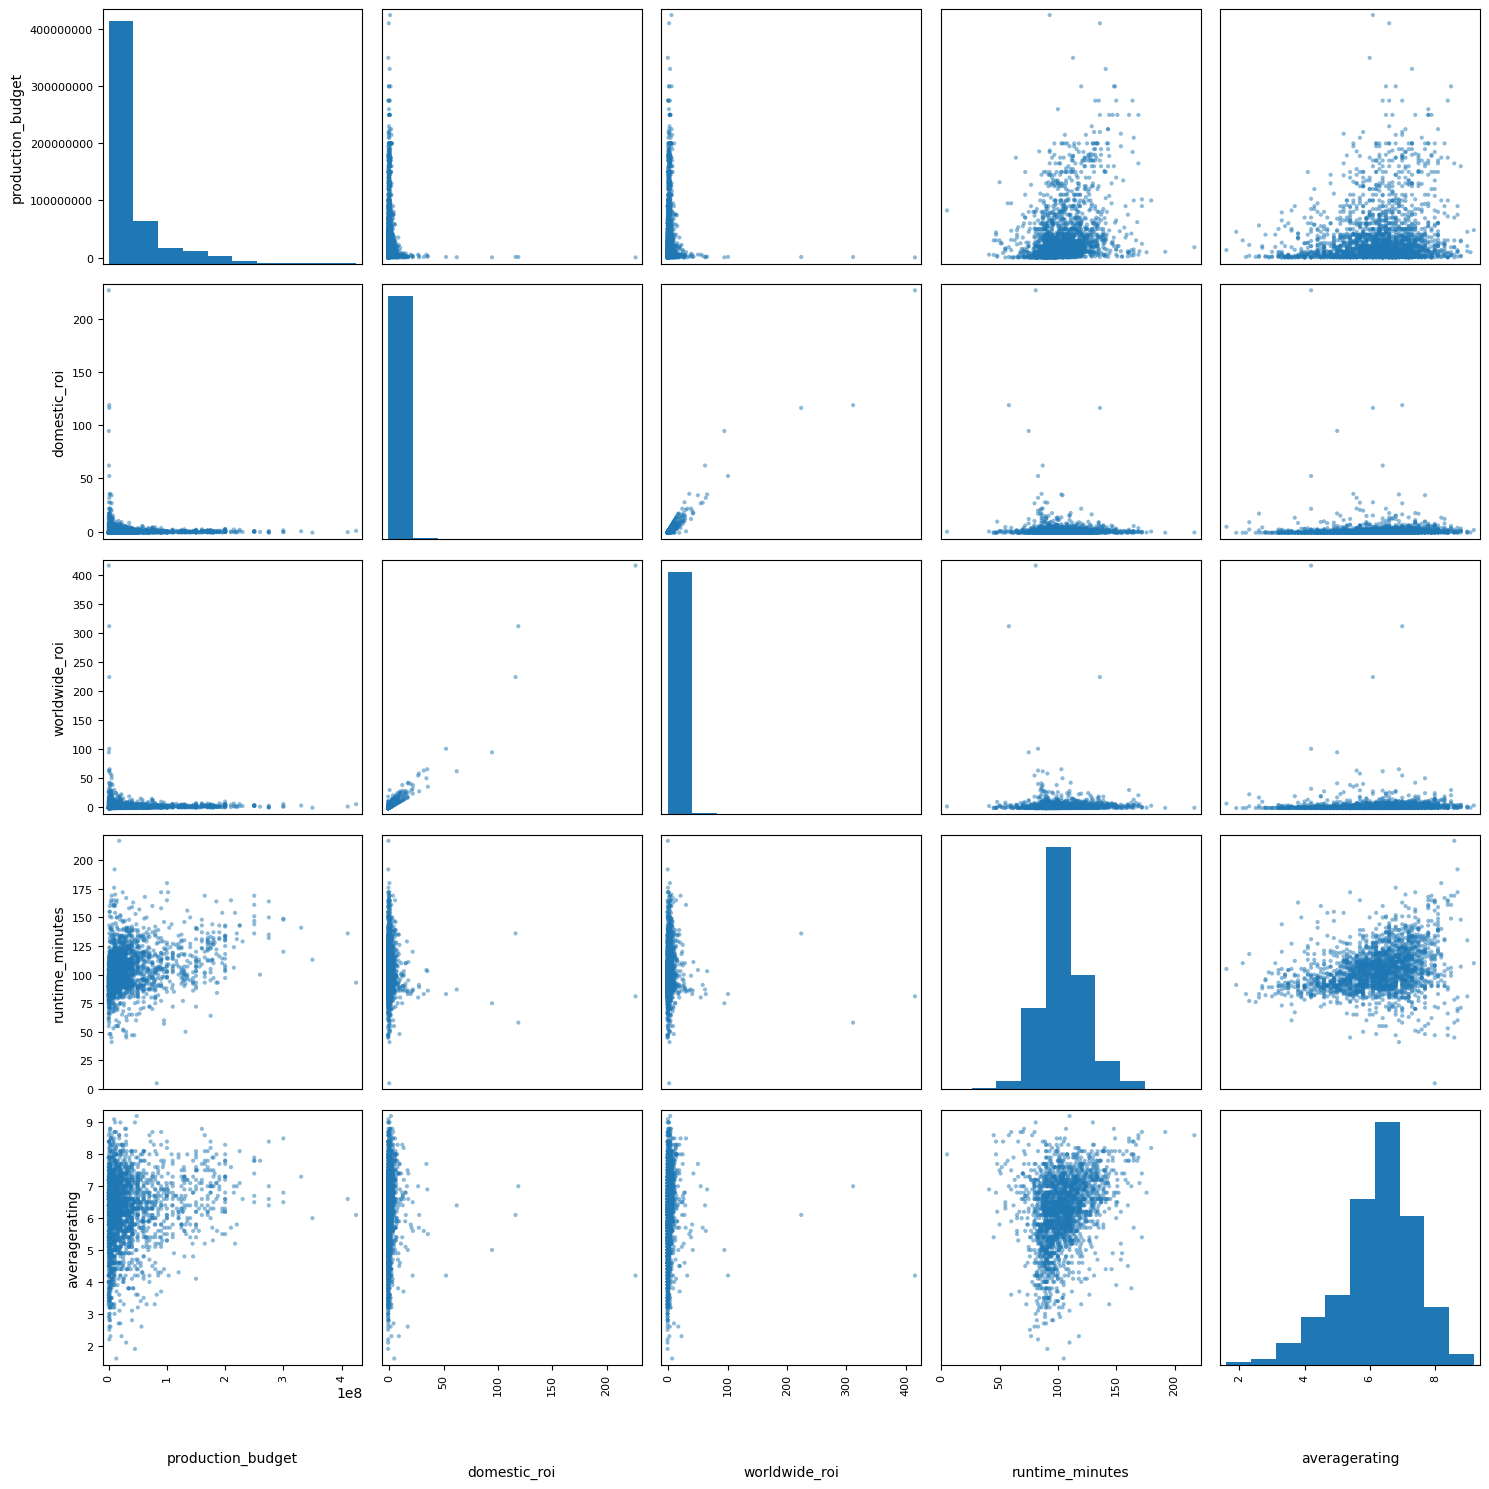

In [12]:
# Increase the size using figsize argument
axs = pd.plotting.scatter_matrix(df_merge[['production_budget', 'domestic_roi', 'worldwide_roi', 'runtime_minutes', 'averagerating']], figsize=(15, 15))

# Rotate x-axis labels
for ax in axs[:, 0]: # only the leftmost column
    ax.xaxis.label.set_rotation(90)

for ax in axs[-1, :]: # only the bottom row
    ax.xaxis.label.set_rotation(0)
    ax.xaxis.labelpad = 50

# Adjust the layout
plt.tight_layout()
plt.show()

## Most profitable genre

Drama          1094
Comedy          664
Action          525
Adventure       402
Thriller        364
Crime           294
Horror          273
Romance         258
Sci-Fi          174
Biography       170
Mystery         166
Fantasy         146
Documentary     126
Family          123
Animation       119
Music            68
History          56
Sport            46
War              29
Musical          15
Western          13
News              1
Name: count, dtype: int64


<Axes: >

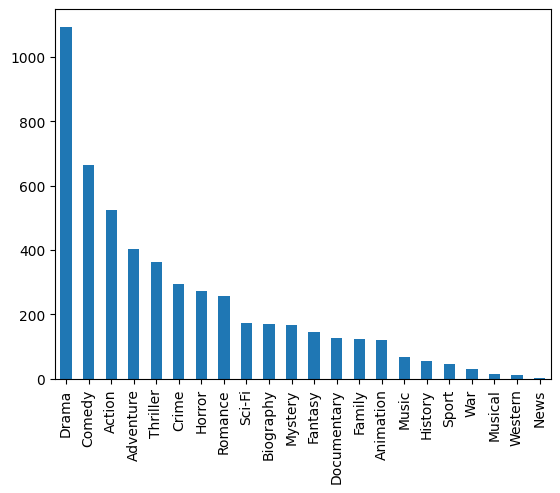

In [13]:
# Calculate and visualize most common genres 
all_genres = [item for sublist in df_merge['genres'] if sublist is not None for item in sublist]
genre_counts = pd.Series(all_genres).value_counts(dropna=False)

print(genre_counts) 
genre_counts.plot(kind='bar')

In [14]:
# Function to get lists of values for each genre
def get_genre_vals(val, df):   
    df_len = len(df)
    all_genre_vals = {}
    
    for genre in genre_counts.index:    
        genre_vals = df[df['genres'].apply(lambda x: genre in x if x is not None else False)][val].values
        genre_len = len(genre_vals) 
        if genre_len < 30:
            continue 
        diff_length = df_len - genre_len
        genre_vals = np.concatenate([genre_vals, [np.nan]*diff_length])
        all_genre_vals[genre] = genre_vals
    all_genre_vals = pd.DataFrame(all_genre_vals)
    all_genre_vals = all_genre_vals.dropna(how='all').reset_index(drop=True)
    return all_genre_vals 

Text(0.5, 1.0, 'Worldwide ROI By Genre')

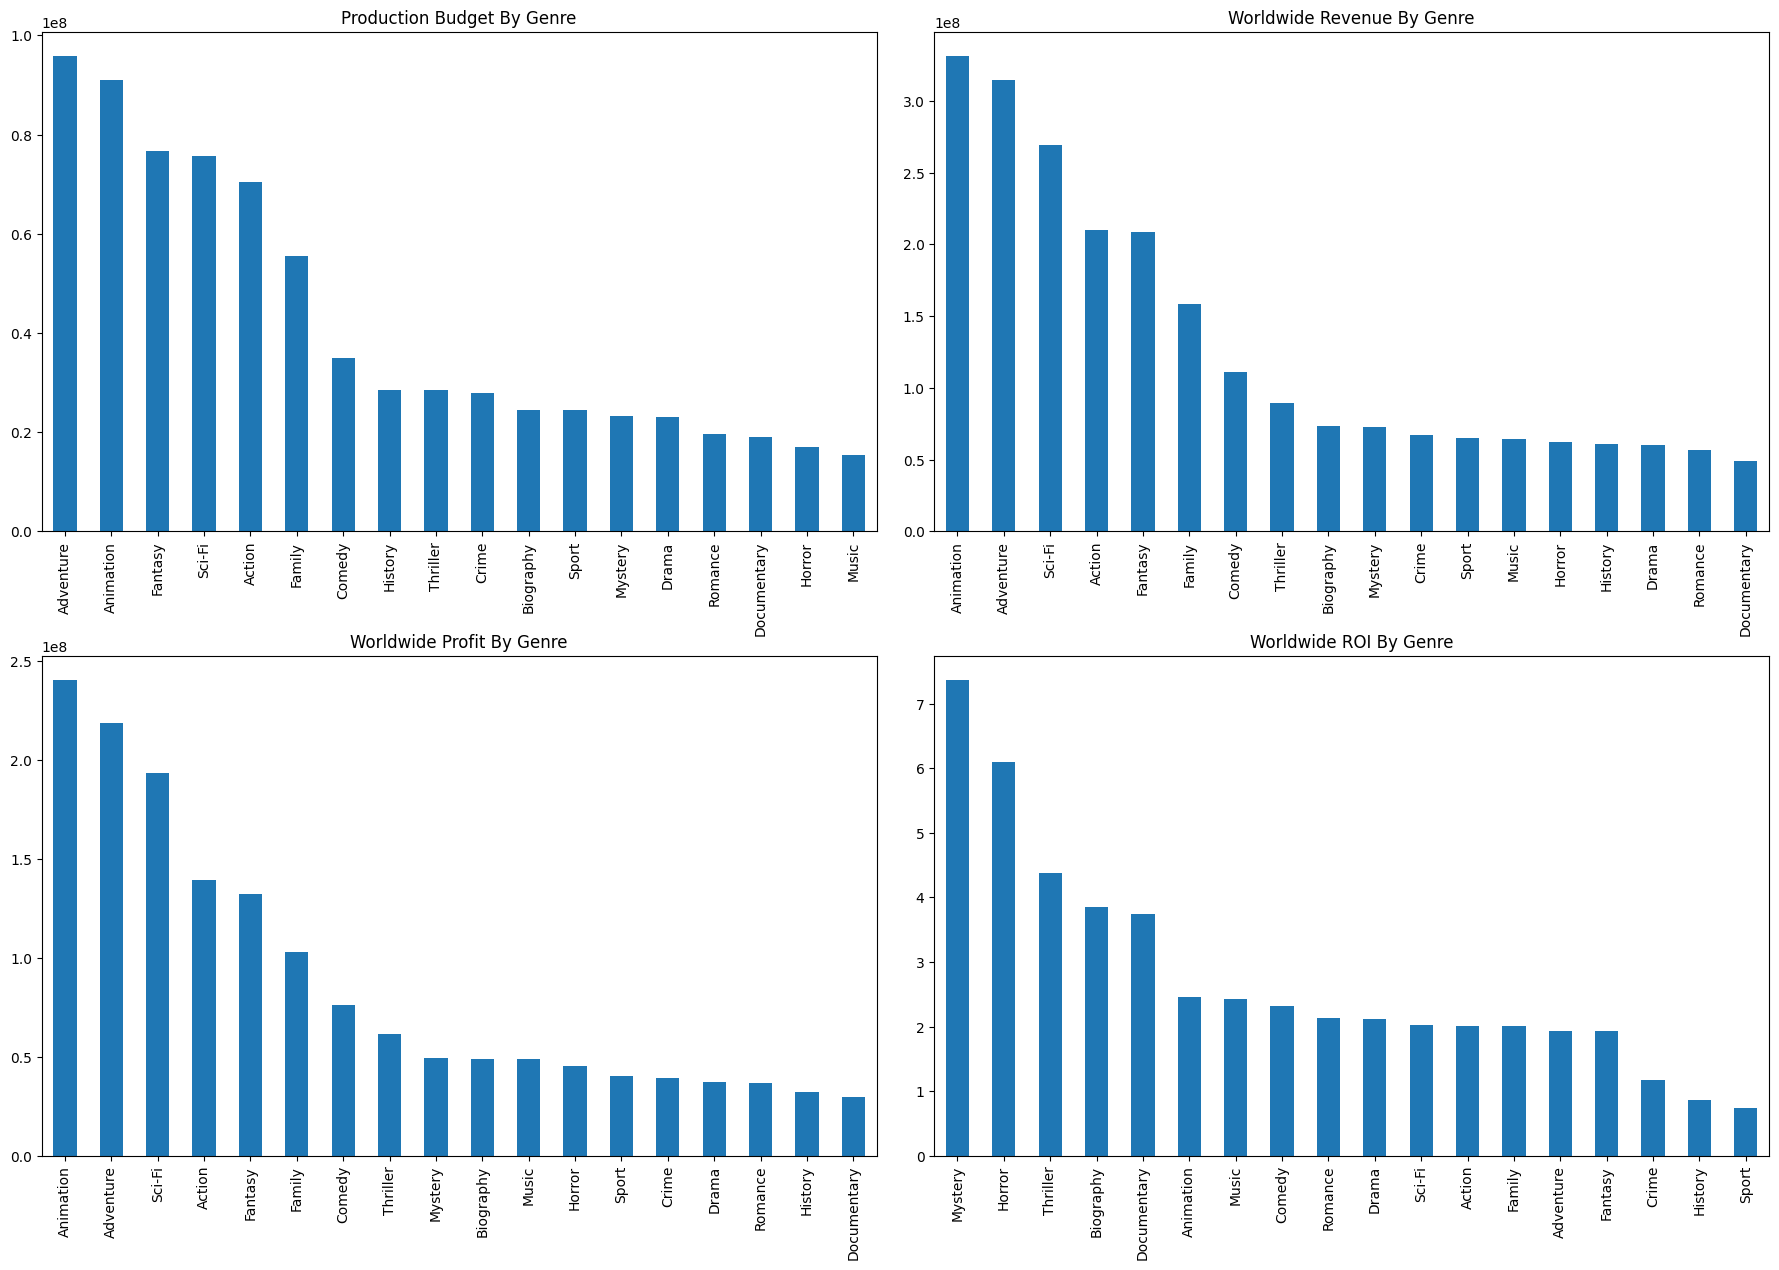

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Get lists of budgets for each genre and plot
genre_vals = get_genre_vals('production_budget', df_merge)
mean_genre_vals = genre_vals.mean().sort_values(ascending=False)
mean_genre_vals.plot.bar(ax=axes[0,0])
axes[0,0].set_title('Production Budget By Genre')
plt.tight_layout()

# Get lists of worldwide gross earnings for each genre and plot
genre_vals = get_genre_vals('worldwide_gross', df_merge)
mean_genre_vals = genre_vals.mean().sort_values(ascending=False)
mean_genre_vals.plot.bar(ax=axes[0,1])
axes[0,1].set_title('Worldwide Revenue By Genre')

# Get lists of worldwide gross profit for each genre and plot
genre_vals = get_genre_vals('worldwide_profit', df_merge)
mean_genre_vals = genre_vals.mean().sort_values(ascending=False)
mean_genre_vals.plot.bar(ax=axes[1,0])
axes[1,0].set_title('Worldwide Profit By Genre')

# Get lists of worldwide gross profit for each genre and plot
genre_vals = get_genre_vals('worldwide_roi', df_merge)
mean_genre_vals = genre_vals.mean().sort_values(ascending=False)
mean_genre_vals.plot.bar(ax=axes[1,1])
axes[1,1].set_title('Worldwide ROI By Genre')

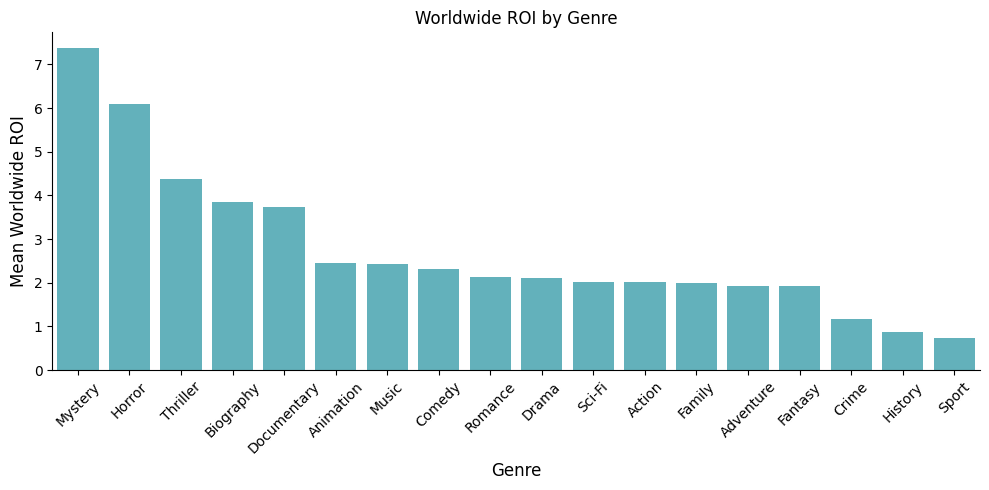

In [16]:
plt.figure(figsize=(10, 5))

# Get lists of worldwide gross profit for each genre and plot
genre_vals = get_genre_vals('worldwide_roi', df_merge)
mean_genre_vals = genre_vals.mean().sort_values(ascending=False)


sns.barplot(x=mean_genre_vals.index, y=mean_genre_vals.values, color='#54BDCA')

# Customize the plot (e.g., set labels, rotate x-axis labels)
plt.xticks(rotation=45)
plt.xlabel('Genre', size=12)
plt.ylabel('Mean Worldwide ROI', size=12)
plt.title('Worldwide ROI by Genre')

# Show the plot
plt.tight_layout()
sns.despine()

In [17]:
# Define the genres to check for
genres_to_check = ['Mystery', 'Horror', 'Thriller']

# Create the 'top_3_genres' column
df_merge['top_3_genres'] = df_merge['genres'].apply(lambda x: [1 if (x is not None) and (genre in x) else 0 for genre in genres_to_check])
df_merge['top_3_genres'] = df_merge['top_3_genres'].apply(tuple)
df_merge.groupby('top_3_genres')['worldwide_roi'].mean()

top_3_genres
(0, 0, 0)     2.196778
(0, 0, 1)     1.681655
(0, 1, 0)     2.924082
(0, 1, 1)     2.810900
(1, 0, 0)     1.127531
(1, 0, 1)     2.174798
(1, 1, 0)     3.606411
(1, 1, 1)    27.856694
Name: worldwide_roi, dtype: float64

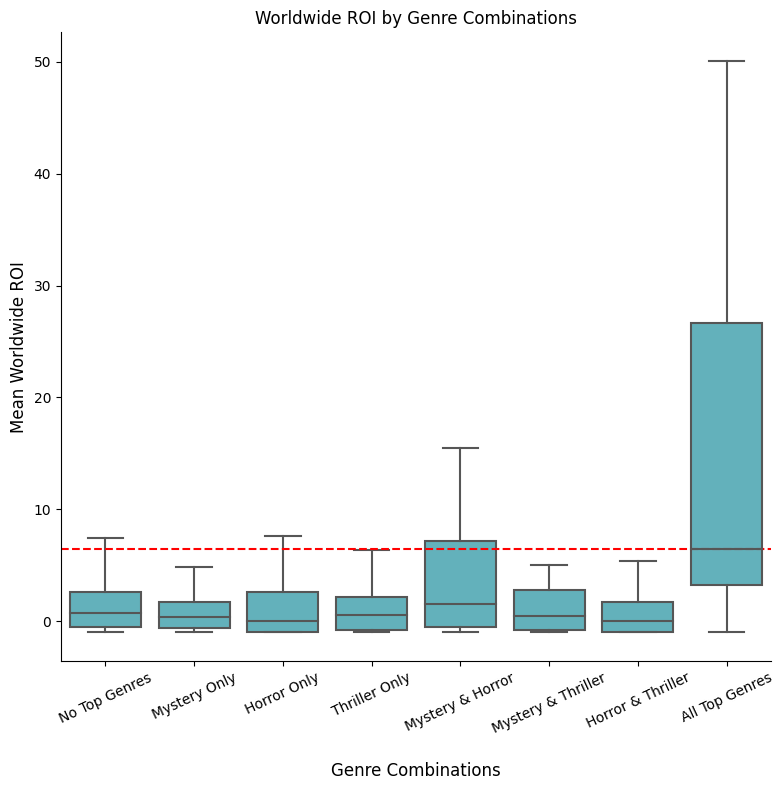

In [18]:
plt.figure(figsize=(8, 8))

['Mystery', 'Horror', 'Thriller']

order = [(0,0,0), (1,0,0), (0,1,0), (0,0,1), (1,1,0), (1,0,1), (0,1,1), (1,1,1)]
labels = ['No Top Genres', 'Mystery Only', 'Horror Only', 'Thriller Only',
          'Mystery & Horror', 'Mystery & Thriller', 'Horror & Thriller', 'All Top Genres' ]
          
sns.boxplot(data=df_merge, x='top_3_genres', y='worldwide_roi', order = order, showfliers=False, color='#54BDCA')

all_top_med = df_merge[df_merge['top_3_genres'] == (1,1,1)]['worldwide_roi'].median()
plt.axhline(all_top_med, linestyle = '--', color='r')
plt.xticks(range(len(order)), labels, rotation=25)
plt.xlabel('\nGenre Combinations', size=12)
plt.ylabel('Mean Worldwide ROI', size=12)
plt.title('Worldwide ROI by Genre Combinations')

# Show the plot
plt.tight_layout()
sns.despine()

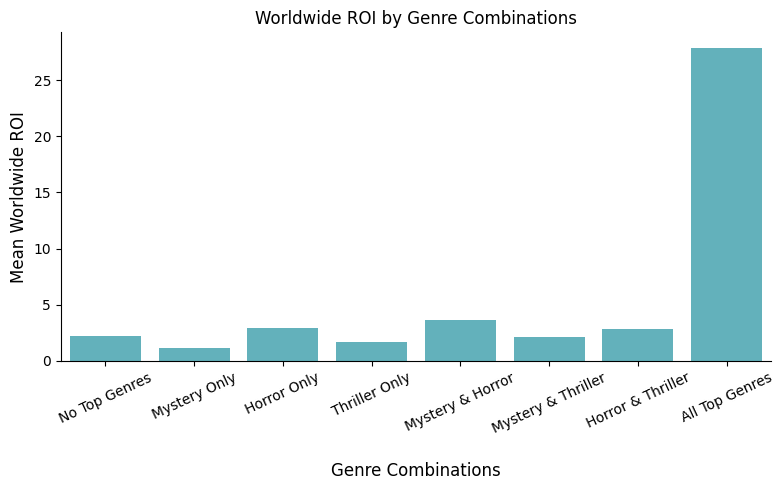

In [19]:
plt.figure(figsize=(8, 5))

['Mystery', 'Horror', 'Thriller']

order = [(0,0,0), (1,0,0), (0,1,0), (0,0,1), (1,1,0), (1,0,1), (0,1,1), (1,1,1)]
labels = ['No Top Genres', 'Mystery Only', 'Horror Only', 'Thriller Only',
          'Mystery & Horror', 'Mystery & Thriller', 'Horror & Thriller', 'All Top Genres' ]
          
sns.barplot(data =df_merge, x='top_3_genres', y='worldwide_roi', order = order, ci=False, color='#54BDCA')
plt.xticks(range(len(order)), labels, rotation=25)
plt.xlabel('\nGenre Combinations', size=12)
plt.ylabel('Mean Worldwide ROI', size=12)
plt.title('Worldwide ROI by Genre Combinations')

# Show the plot
plt.tight_layout()
sns.despine()

In [20]:
df_subset = df_merge[df_merge['top_3_genres'] == (1,1,1)].reset_index(drop=True)

## Runtime

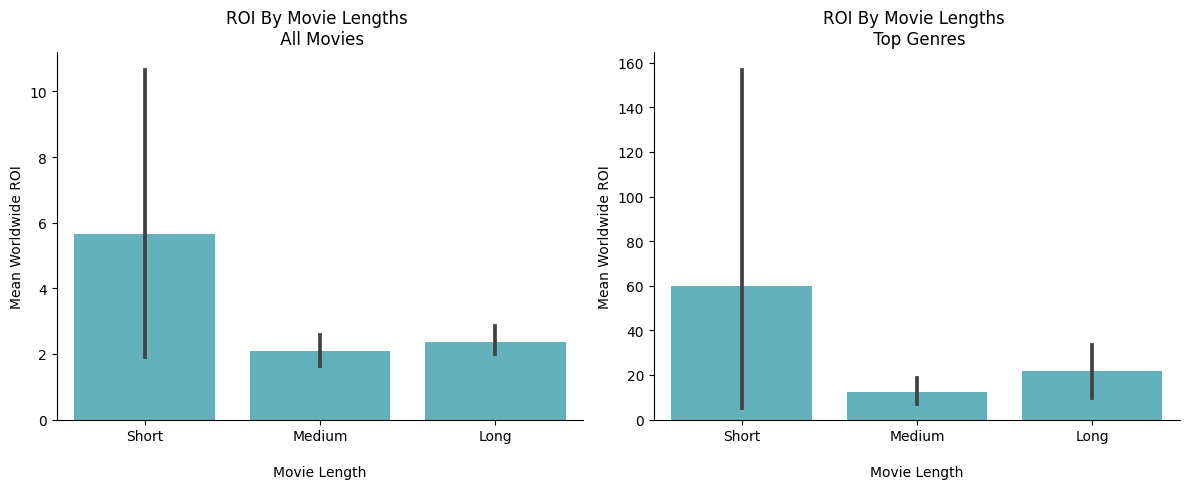

In [21]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.barplot(x='rt_cat', y='worldwide_roi', data=df_merge, order=["Short", "Medium", "Long"], ax=axes[0], color='#54BDCA')
axes[0].set_title('ROI By Movie Lengths \n All Movies')
axes[0].set_ylabel('Mean Worldwide ROI')
axes[0].set_xlabel('\nMovie Length')

sns.barplot(x='rt_cat', y='worldwide_roi', data=df_subset, order=["Short", "Medium", "Long"], ax=axes[1], color='#54BDCA')
axes[1].set_title('ROI By Movie Lengths \n Top Genres')
axes[1].set_ylabel('Mean Worldwide ROI')
axes[1].set_xlabel('\nMovie Length')

plt.tight_layout()
sns.despine()

## Annual Trends

In [22]:
df_merge['release_date'] = pd.to_datetime(df_merge['release_date'])
df_merge['month'] = df_merge['release_date'].dt.month

df_subset['release_date'] = pd.to_datetime(df_subset['release_date'])
df_subset['month'] = df_subset['release_date'].dt.month

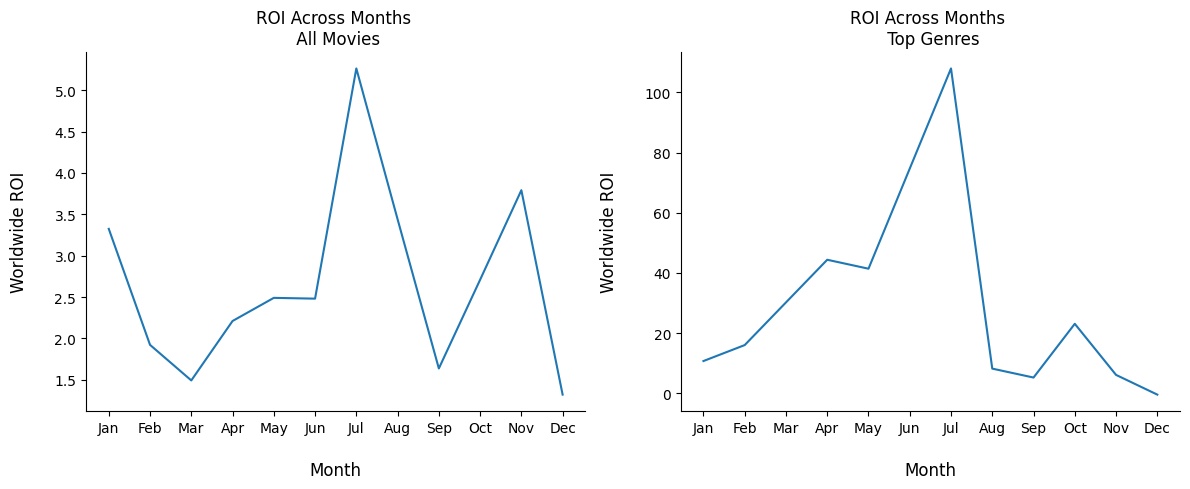

In [23]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

df_merge.groupby('month')['worldwide_roi'].mean().plot(kind='line', ax=axes[0])
axes[0].set_title('ROI Across Months \n All Movies')
axes[0].set_xlabel('\nMonth', size=12)
axes[0].set_ylabel('Worldwide ROI\n', size=12)
axes[0].set_xticks(range(1,13))
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

df_subset.groupby('month')['worldwide_roi'].mean().plot(kind='line', ax=axes[1])
axes[1].set_title('ROI Across Months \n Top Genres')
axes[1].set_xlabel('\nMonth', size=12)
axes[1].set_ylabel('Worldwide ROI\n', size=12)
axes[1].set_xticks(range(1,13))
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
sns.despine()

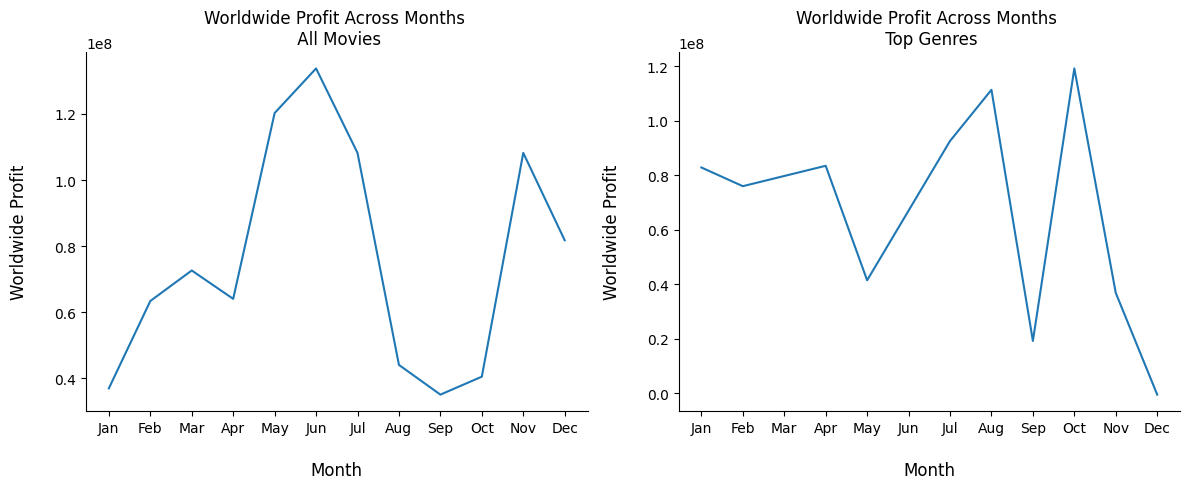

In [24]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

df_merge.groupby('month')['worldwide_profit'].mean().plot(kind='line', ax=axes[0])
axes[0].set_title('Worldwide Profit Across Months \n All Movies')
axes[0].set_xlabel('\nMonth', size=12)
axes[0].set_ylabel('Worldwide Profit\n', size=12)
axes[0].set_xticks(range(1,13))
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

df_subset.groupby('month')['worldwide_profit'].mean().plot(kind='line', ax=axes[1])
axes[1].set_title('Worldwide Profit Across Months \n Top Genres')
axes[1].set_xlabel('\nMonth', size=12)
axes[1].set_ylabel('Worldwide Profit\n', size=12)
axes[1].set_xticks(range(1,13))
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
sns.despine()

## Writers & Directors

#### Get the directors and writer data

In [25]:
directors = pd.read_sql("""SELECT b.movie_id, b.original_title, p.primary_name AS director
                            FROM movie_basics AS b
                            JOIN directors AS d USING (movie_id)
                            JOIN persons AS p USING (person_id)
                            """, conn)
directors.drop_duplicates(subset=['movie_id', 'original_title', 'director'], inplace=True)

In [26]:
writers = pd.read_sql("""SELECT b.movie_id, b.original_title, p.primary_name AS writer
                            FROM movie_basics AS b
                            JOIN writers AS d USING (movie_id)
                            JOIN persons AS p USING (person_id)
                            """, conn)

writers.drop_duplicates(subset=['movie_id', 'original_title', 'writer'], inplace=True)

#### Make two data frames for Df_merge combined with writers and directors separately

In [27]:
df_merge_writer = df_merge.merge(writers, on='movie_id', how='inner')
df_merge_director = df_merge.merge(directors, on='movie_id', how='inner')

#### Make another data frame that has the count and the average of ROIs for each director
#### Then filter the data to get the Director having a good ROI with more than 4 movies in 

In [28]:
x = df_merge_director.groupby('director')['worldwide_roi'].mean()
y = df_merge_director.groupby('director')['worldwide_roi'].count()
directors_roi_count = pd.concat([x, y], keys=['roi', 'count'], axis=1)
directors_roi_count[(directors_roi_count['roi']>15) & (directors_roi_count['count']>3)]

,roi,count
director,,
James Wan,23.410492,4


In [29]:
df_merge_director[df_merge_director['director']=='James Wan']

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,domestic_roi,worldwide_profit,worldwide_roi,...,runtime_minutes,genres,averagerating,numvotes,complexity,rt_cat,top_3_genres,month,original_title,director
55,67,2015-04-03,furious 7,190000000,353007020,1518722794,163007020,0.857932,1328722794,6.993278,...,137.0,"[Action, Crime, Thriller]",7.2,335074,High,Long,"(0, 0, 1)",4,Furious Seven,James Wan
117,36,2018-12-21,aquaman,160000000,335061807,1146894640,175061807,1.094136,986894640,6.168092,...,143.0,"[Action, Adventure, Fantasy]",7.1,263328,High,Long,"(0, 0, 0)",12,Aquaman,James Wan
1091,93,2013-07-19,the conjuring,20000000,137400141,318000141,117400141,5.870007,298000141,14.900007,...,112.0,"[Horror, Mystery, Thriller]",7.5,397233,High,Long,"(1, 1, 1)",7,The Conjuring,James Wan
2107,63,2011-04-01,insidious,1500000,54009150,99870886,52509150,35.006100,98370886,65.580591,...,103.0,"[Horror, Mystery, Thriller]",6.9,254197,High,Long,"(1, 1, 1)",4,Insidious,James Wan


#### James wan has 4 movies in our dataset, averaging a 23.4 ROI, two of his movies were of the top three genres and they have the highest ROIs amongst his movies

### Repeat the same for the writers

In [30]:
x = df_merge_writer.groupby('writer')['worldwide_roi'].mean()
y = df_merge_writer.groupby('writer')['worldwide_roi'].count()
writers_roi_count = pd.concat([x, y], keys=['roi', 'count'], axis=1)
writers_roi_count[(writers_roi_count['roi']>15) & (directors_roi_count['count']>3)]

,roi,count
writer,,
Christopher Landon,24.91521,6


In [31]:
df_merge_writer[df_merge_writer['writer']=='Christopher Landon']

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,domestic_roi,worldwide_profit,worldwide_roi,...,runtime_minutes,genres,averagerating,numvotes,complexity,rt_cat,top_3_genres,month,original_title,writer
3169,25,2015-10-30,scouts guide to the zombie apocalypse,15000000,3703046,15554855,-11296954,-0.753130,554855,0.036990,...,93.0,"[Action, Comedy, Horror]",6.3,40479,High,Medium,"(0, 1, 0)",10,Scouts Guide to the Zombie Apocalypse,Christopher Landon
3663,78,2019-02-13,happy death day 2u,9000000,28051045,64179495,19051045,2.116783,55179495,6.131055,...,100.0,"[Drama, Horror, Mystery]",6.3,27462,High,Long,"(1, 1, 0)",2,Happy Death Day 2U,Christopher Landon
3942,51,2011-10-21,paranormal activity 3,5000000,104028807,207039844,99028807,19.805761,202039844,40.407969,...,83.0,"[Horror, Mystery, Thriller]",5.8,85689,High,Short,"(1, 1, 1)",10,Paranormal Activity 3,Christopher Landon
3950,59,2012-10-19,paranormal activity 4,5000000,53900335,142817992,48900335,9.780067,137817992,27.563598,...,88.0,"[Horror, Mystery, Thriller]",4.6,58408,High,Medium,"(1, 1, 1)",10,Paranormal Activity 4,Christopher Landon
3960,70,2014-01-03,paranormal activity: the marked ones,5000000,32462372,90904854,27462372,5.492474,85904854,17.180971,...,84.0,"[Horror, Mystery, Thriller]",5.0,37147,High,Short,"(1, 1, 1)",1,Paranormal Activity: The Marked Ones,Christopher Landon
4215,65,2010-10-20,paranormal activity 2,3000000,84752907,177512032,81752907,27.250969,174512032,58.170677,...,91.0,[Horror],5.7,93122,Low,Medium,"(0, 1, 0)",10,Paranormal Activity 2,Christopher Landon


#### Christopher Landon has 6 movies in our dataset, averaging a 24.9 ROI, all of his movies have at least one of the top three genres.